In [1]:
#https://github.com/olgaliak/detection-amlworkbench/tree/master/assets
#!wget https://olgalicodestory.blob.core.windows.net/kittiwakedata/kittiwake_labled.zip
#!unzip kittiwake_labled.zip
#!rm kittiwake_labled.zip

In [2]:
import os
import glob
import json
import numpy as np
import torchvision
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
# Bit messy to use chainercv to visualise ...
from chainercv.visualizations import vis_bbox  # todo

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
PATH = "kittiwake_labled/"

In [4]:
with open(os.path.join(PATH, "train.json"), 'r') as annofile:
    labels = json.load(annofile) 

In [5]:
class BirdsData(Dataset):
    
    def __init__(self, img_dir, lbl_file, transform=None):
        self.img_locs = glob.glob(os.path.join(img_dir, "*.JPG"))
        with open(lbl_file, 'r') as annofile:
            self.labels = json.load(annofile) 
        self.transform = transform
        print("Loaded {} images".format(len(self.img_locs)))
        
    def __getitem__(self, idx):
        im_file = self.img_locs[idx]

        # BBoxes fixed to w=1269,h=952
        # Resized before transform to match label
        im_rgb = Image.open(im_file).resize((1269, 952))
        
        # Bounding boxes: (y_{min}, x_{min}, y_{max}, x_{max}
        img_no = str(int(os.path.basename(
            os.path.splitext(im_file)[0])))
        labels = self.labels['frames'][img_no]
        # 'ymin', 'xmin', 'ymax', 'xmax'
        bboxes = np.array([
            (l['y1'], l['x1'], l['y2'], l['x2']) for l in labels])
        
        # Class labels (start at 0)
        cls_label = np.zeros(len(bboxes))
        
        if self.transform is not None:
            im_rgb = self.transform(im_rgb)
        return im_rgb, torch.FloatTensor(bboxes), torch.FloatTensor(cls_label), 1
        
    def __len__(self):
        return len(self.img_locs)

In [6]:
# Init dataset
train_dataset = BirdsData(
    img_dir = os.path.join(PATH, "train"),
    lbl_file = os.path.join(PATH, "train.json"))

Loaded 160 images


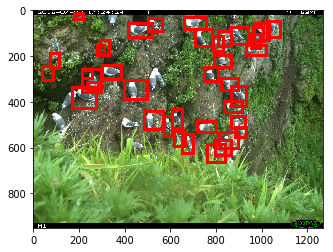

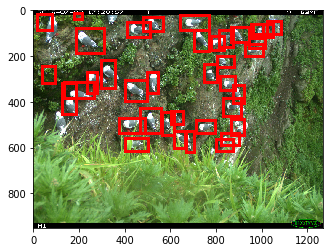

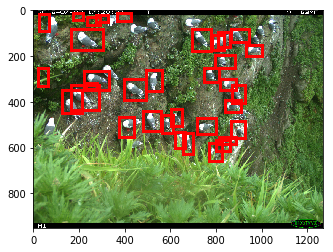

In [7]:
# Visualise rndm images
for i in [5, 16, 55]:
    im, boxes, cls_lab, scale = train_dataset[i]
    im_array = np.moveaxis(np.array(im),-1,0)
    vis_bbox(im_array, boxes)

In [8]:
# Train Default Model

In [9]:
# Model specific imports
from model.faster_rcnn import FasterRCNN
from model.region_proposal_network import RegionProposalNetwork
from model.faster_rcnn_vgg16 import VGG16RoIHead, decom_vgg16
# Training imports
import torchvision.transforms as transforms
from tqdm import tqdm
from trainer import FasterRCNNTrainer
from utils import array_tool as at
# Test prediction
from model.utils.bbox_tools import loc2bbox
from torch.nn import functional as F

/home/iliauk/simple-faster-rcnn-pytorch/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


In [10]:
# Normalise by imagenet mean/sd
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_SD = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(IMAGENET_RGB_MEAN,
                                 IMAGENET_RGB_SD)

img_trans = transforms.Compose([transforms.ToTensor(), normalize])

# Init dataset
train_dataset = BirdsData(
    img_dir = os.path.join(PATH, "train"),
    lbl_file = os.path.join(PATH, "train.json"), 
    transform=img_trans)

# Loader
dataloader = DataLoader(train_dataset, 
                        batch_size=1,
                        shuffle=True)

Loaded 160 images


In [11]:
# Model: Default using VGG16
class FasterRCNNVGG16(FasterRCNN):

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]):
                 
        # Note that vgg16 is used for backbone and classifier 
        extractor, classifier = decom_vgg16()
        #print("Backbone: ", extractor)
        
        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride)
        print("Region Proposal Network: ", rpn)

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier)
        print("Head: ", head)
        
        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head)

In [12]:
# Initiate model
faster_rcnn = FasterRCNNVGG16()

Region Proposal Network:  RegionProposalNetwork(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (score): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (loc): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
)
Head:  VGG16RoIHead(
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace)
  )
  (cls_loc): Linear(in_features=4096, out_features=84, bias=True)
  (score): Linear(in_features=4096, out_features=21, bias=True)
  (roi): RoIPooling2D()
)


In [13]:
# Initiate trainer with model
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

In [14]:
def try_prediction(img_arr):
    # Eval mode
    trainer.faster_rcnn.eval()
    
    # Forward pass only
    roi_cls_loc, roi_scores, rois, _ = trainer.faster_rcnn(img_arr)
    scale = 1 
    # We are assuming that batch size is 1.
    roi_score = roi_scores.data
    roi_cls_loc = roi_cls_loc.data
    roi = at.totensor(rois) / scale
    
    # Convert predictions to bounding boxes in image coordinates.
    # Bounding boxes are scaled to the scale of the input images.
    mean = torch.Tensor(trainer.faster_rcnn.loc_normalize_mean).cuda(). \
        repeat(trainer.faster_rcnn.n_class)[None]
    std = torch.Tensor(trainer.faster_rcnn.loc_normalize_std).cuda(). \
        repeat(trainer.faster_rcnn.n_class)[None]
    
    roi_cls_loc = (roi_cls_loc * std + mean)
    roi_cls_loc = roi_cls_loc.view(-1, trainer.faster_rcnn.n_class, 4)
    roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
    cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)),
                        at.tonumpy(roi_cls_loc).reshape((-1, 4)))
    cls_bbox = at.totensor(cls_bbox)
    cls_bbox = cls_bbox.view(-1, trainer.faster_rcnn.n_class * 4)
    # clip bounding box
    cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=1269)
    cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=1269)
    
    prob = at.tonumpy(F.softmax(roi_score, dim=-1))

    raw_cls_bbox = at.tonumpy(cls_bbox)  # 300, 
    raw_prob = at.tonumpy(prob)

    pred_bbox, pred_label, pred_score = trainer.faster_rcnn._suppress(raw_cls_bbox, raw_prob)
    return pred_bbox, pred_label, pred_score

In [15]:
def viz_predict_eval_image(input_image, augment=False):
    # Input image
    test_im = Image.open(input_image).resize((1269, 952))
    # Augment?
    if augment:
        test_im = img_aug(test_im)
    # Transforms   
    test_arr = img_trans(test_im)
    test_arr = torch.Tensor(np.expand_dims(test_arr, axis=0))
    test_arr = test_arr.cuda()
    # Predict on image
    pred_bbox, pred_label, pred_score = try_prediction(test_arr)
    # Visualise
    vis_bbox(np.moveaxis(np.array(test_im),-1,0), pred_bbox)
    return len(pred_bbox)

410

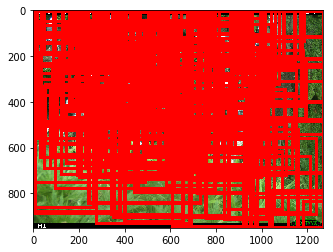

In [16]:
# Predict random image untrained
viz_predict_eval_image('kittiwake_labled/test/255.JPG')

In [17]:
# Train one-epoch
for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
    #scale (float): Amount of scaling applied to the raw image during preprocessing
    scale = at.scalar(scale)
    img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
    trainer.train_step(img, bbox, label, scale)
    if ii % 20 == 0:
        print(ii, trainer.get_meter_data())

1it [00:00,  2.44it/s]

0 {'roi_cls_loss': 3.006002187728882, 'rpn_loc_loss': 0.6582142114639282, 'roi_loc_loss': 0.0014243923360481858, 'rpn_cls_loss': 0.7101579308509827, 'total_loss': 4.37579870223999}


21it [00:09,  2.24it/s]

20 {'roi_cls_loss': 0.9857005193119958, 'rpn_loc_loss': 0.4991320641267868, 'roi_loc_loss': 0.2389091965021743, 'rpn_cls_loss': 0.6527792357263112, 'total_loss': 2.3765210253851756}


41it [00:19,  2.09it/s]

40 {'roi_cls_loss': 0.7102088353982786, 'rpn_loc_loss': 0.39219616753299075, 'roi_loc_loss': 0.2548308738865094, 'rpn_cls_loss': 0.6003177943753033, 'total_loss': 1.9575536658124226}


61it [00:29,  2.08it/s]

60 {'roi_cls_loss': 0.6297963877193264, 'rpn_loc_loss': 0.34113108745363896, 'roi_loc_loss': 0.2881505303218441, 'rpn_cls_loss': 0.5646395365722845, 'total_loss': 1.82371753747346}


81it [00:39,  2.08it/s]

80 {'roi_cls_loss': 0.5908799892590373, 'rpn_loc_loss': 0.310301414610427, 'roi_loc_loss': 0.3030835967381588, 'rpn_cls_loss': 0.5247456836111752, 'total_loss': 1.72901068057543}


101it [00:48,  2.07it/s]

100 {'roi_cls_loss': 0.5777052817958419, 'rpn_loc_loss': 0.3307497604648665, 'roi_loc_loss': 0.32160129520631775, 'rpn_cls_loss': 0.5000348362592187, 'total_loss': 1.7300911728698432}


121it [00:58,  2.07it/s]

120 {'roi_cls_loss': 0.562964565744085, 'rpn_loc_loss': 0.3106441171454988, 'roi_loc_loss': 0.3335274604239601, 'rpn_cls_loss': 0.4723726796709801, 'total_loss': 1.6795088200529749}


141it [01:07,  2.08it/s]

140 {'roi_cls_loss': 0.5511072085681538, 'rpn_loc_loss': 0.2966290030707704, 'roi_loc_loss': 0.34457007228109515, 'rpn_cls_loss': 0.4461101358029859, 'total_loss': 1.6384164171015967}


160it [01:16,  2.10it/s]


45

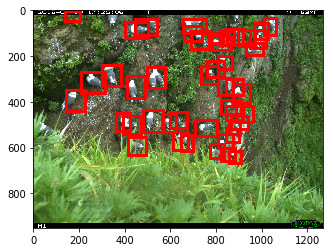

In [18]:
# Try again
viz_predict_eval_image('kittiwake_labled/test/213.JPG')

46

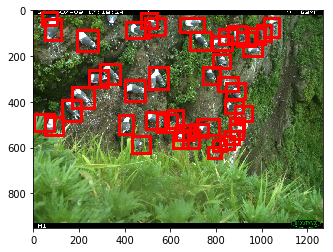

In [19]:
# Try again
viz_predict_eval_image('kittiwake_labled/test/222.JPG')

In [20]:
# Make things more difficult
img_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)])

48

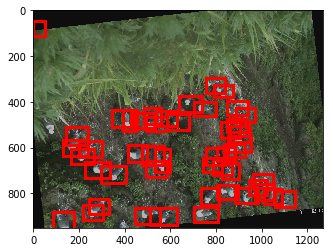

In [21]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG',
                       augment=True)

41

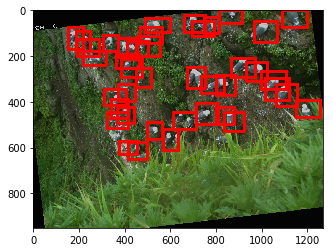

In [22]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG',
                       augment=True)

51

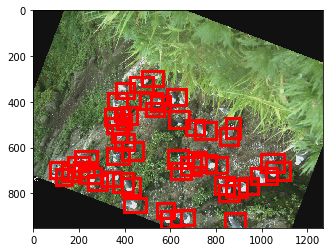

In [23]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG',
                       augment=True)

41

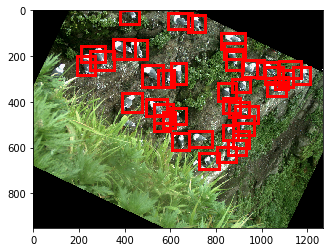

In [24]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG',
                       augment=True)

## RPN Forward-Pass

Ref: https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439

In [51]:
# Sample image
loc_img = 'kittiwake_labled/test/222.JPG'
input_img = Image.open(loc_img).resize((1269, 952))
# Transform to array
test_arr = img_trans(input_img)
test_arr = torch.Tensor(np.expand_dims(test_arr, axis=0))
test_arr = test_arr.cuda()

In [52]:
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

In [53]:
# Pass img through CNN backbone
features = trainer.faster_rcnn.extractor(test_arr)
# Feature vector
print(features.shape)  # torch.Size([1, 512, 59, 79])

torch.Size([1, 512, 59, 79])


In [54]:
# Pass features through RPN
print(trainer.faster_rcnn.rpn)
img_size, scale = (1269, 952), 1
rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            trainer.faster_rcnn.rpn(features, img_size, scale)

RegionProposalNetwork(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (score): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (loc): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
)


In [55]:
print(rpn_locs.shape)  # torch.Size([1, 41949, 4])
print(rpn_scores.shape)  # torch.Size([1, 41949, 2])

# Top 2000 while training / 300 while testing
# RPN_locs are offsets to the anchors
# ROIs are image-coordinates of top 300 RPN_loc scores
# *I think* ... to check
print(rois.shape)  # (300, 4)
print(roi_indices.shape)  # (300,) 
print(anchor.shape) # (41949, 4)

torch.Size([1, 41949, 4])
torch.Size([1, 41949, 2])
(300, 4)
(300,)
(41949, 4)


In [56]:
# Regions of interest sample (300 for testing)
# These are in actual coordinates
rois[:10]

array([[121.66776, 754.81744, 178.68802, 819.0948 ],
       [115.03471, 761.94226, 170.2274 , 824.59045],
       [562.5937 , 807.72174, 621.1025 , 868.07416],
       [121.24605, 768.18744, 172.92265, 841.3592 ],
       [549.2483 , 819.29193, 607.4259 , 879.4982 ],
       [559.43933, 798.69037, 620.2997 , 857.8885 ],
       [480.17007, 841.8957 , 535.34705, 895.1596 ],
       [109.06586, 790.04987, 164.3552 , 852.2896 ],
       [474.39203, 849.65497, 530.242  , 906.89056],
       [147.98349, 925.1353 , 202.38092, 952.     ]], dtype=float32)

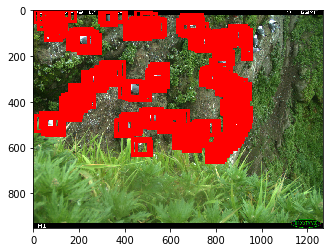

In [57]:
# Visualise the ROIs
vis_bbox(np.moveaxis(np.array(input_img),-1,0), rois)
# This need a bit of non max supression

In [58]:
import cupy as cp
from model.utils.nms import non_maximum_suppression

In [59]:
# Corresponding scores for top RPs
rpn_scores = at.tonumpy(F.softmax(
    np.squeeze(rpn_scores.data), dim=1))
rpn_scores = np.squeeze(rpn_scores)[:,1]  # fore-ground class

In [60]:
# Sort so that most probable scores first
sort_rpn_scores = np.sort(rpn_scores, axis=0)[::-1]
# Truncate to how many boxes there are
# I.e. the scores for these
# ROIs should be sorted by score from highest to lowest
sort_rpn_scores = sort_rpn_scores[:len(rois)]

In [61]:
# nms_threshold 0.3 for visualisation
keep_idx = non_maximum_suppression(
    cp.array(rois), 0.3, sort_rpn_scores)
print(len(keep_idx))

54


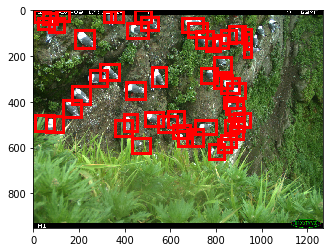

In [62]:
# Visualise the ROIs
vis_bbox(np.moveaxis(np.array(input_img),-1,0), rois[keep_idx])

46

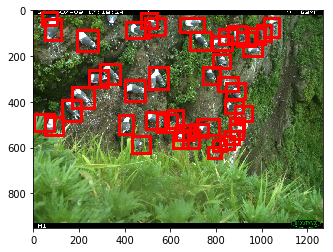

In [63]:
# Compare to full-network prediction
viz_predict_eval_image('kittiwake_labled/test/222.JPG')